# Introduction to Graph Convolutional Network (GCN)
## 1. Overview
* Graph Convolutional Network (GCN) is a neural network which operates on graphs.
* How GCNs work in general?
    * GCN can be understood as a simple message passing algorithm. 
    ![img](image/message_passing.png)
    * The idea of message passing in a graph is a really powerful concept because a lot of graph algorithms can be understood from that perspective. In a nutshell the idea is that a node in a graph can send and receive messages along its connections with its neighbors. 
    * This can be thought of as happening in two steps: first, nodes will send out a message about itself to its neighbors and next, nodes collect the neighbor messages they receive and use them in some way to update itself and understand its environment. 
    * Let's make this concrete by talking through a simple calculation and GCN layer.
    
   ![img](image/message_passing2.png)

For any node in the graph, first get all of the attribute vectors of its connected nodes, and apply some aggregation function (propagation rule) like an average. It makes some intuitive sense that a node might be represented by the average of its neighbors. Next, pass this average vector through a dense neural network layer which is a fancy way of saying multiply it by some matrix and apply an activation function. The output of this dense layer is the new vector representation of the node. So now, a node is not just an average of its neighbor but the average of its neigbors passed through some nonlinear function. So this is the process of how a single GCN layer works. 

# 2. Example of Code
* Given a graph $G = (V, E)$ takes as input:
    * An input feature matrix $N \times F^0$ feature matrix, $X$, where $N$ is the number of nodes and $F^0$ is the number of input features for each node, and
    * An $N \times N$ matrix representation of the graph structure such as the adjacency matrix $A$ of $G$.
* A hidden layer in GCN can be written as $H^i = f(H^{i-1}, A))$ where $H^0 = X$ and $f$ is a propagation. Each layer $H^i$ corresponds to an $N \times F^i$ feature matrix where each row is a feature representation of a node.
* The specific models then differ only in the choice of $f$. One of the simplesr possible propagation rule is:

    $f(H^i, A) = \sigma(AH^iW^i)$

    where $W^i$ is the weight matrix for layer $i$ and $\sigma$ is a non-linear activation function.



### Let's create a simple directed graph
https://networkx.org/documentation/stable/tutorial.html#creating-a-graph

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from scipy.linalg import fractional_matrix_power
from spektral import utils

In [39]:
np.set_printoptions(precision=3)

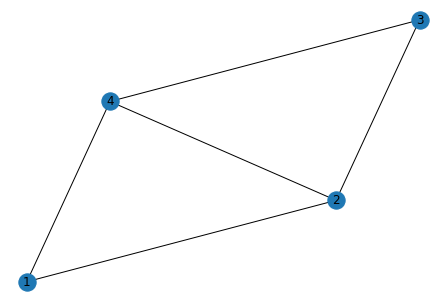

In [18]:
G = nx.Graph(directed=True)
G.add_nodes_from([1,2,3,4])
G.add_edges_from([(1,2), (2,3), (2,4), (4,1),(4,3)])
nx.draw(G, with_labels=True)

### Find the adjacency matrix

In [14]:
A = nx.adjacency_matrix(G).todense()
A

matrix([[0, 1, 0, 1],
        [1, 0, 1, 1],
        [0, 1, 0, 1],
        [1, 1, 1, 0]], dtype=int64)

Since we have 4 nodes so our adjacency matrix have 4 rows and 4 column. The first row will encode all the connections of node 1. Since node 1 is only connected with node 2 and 4, we have the value of 1 in second and fourth column, and zero in all the others. We do the same for node 2,3,4 in the next rows. 

Next, we need features.  We generate 2 integer features for every node based on its index. This makes it easy to confirm the matrix calculations manually later.


In [20]:
X = np.matrix([[i, -i]
            for i in range(A.shape[0])], dtype=float)
X

matrix([[ 0.,  0.],
        [ 1., -1.],
        [ 2., -2.],
        [ 3., -3.]])

### Applying the Propagation Rule
Let’s examine the propagation rule at its most simple level. Let
* $i = 1$
* $\sigma$ be the identity function
* choose the weight s.t $AH^0W^0 = AXW^0 = AX$

Thus, $f(X,A) = AX$.

In [21]:
A*X

matrix([[ 4., -4.],
        [ 5., -5.],
        [ 4., -4.],
        [ 3., -3.]])

The representation of each node (each row) is now a sum of its neighbors features. In other words, the graph convolutional layer represents each node as an aggregate of its neighborhood. 

### Limitations
* The aggregated representation of a node does not include its own features
* Nodes with large degrees will have large values in their feature representation while nodes with small degrees will have small values. This can be solved by transforming the adjacency matrix $A$ by multiplying it with the inverse degree matrix $D$.
    Thus, our propagation will look like this:
    $f(X,A) = D^{-1} AX$

In [25]:
# trick 1: adding self-loops
I = np.matrix(np.eye(A.shape[0]))
I

matrix([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])

In [26]:
A_hat = A + I
A_hat * X

matrix([[ 4., -4.],
        [ 6., -6.],
        [ 6., -6.],
        [ 6., -6.]])

In [46]:
A_hat

matrix([[1., 1., 0., 1.],
        [1., 1., 1., 1.],
        [0., 1., 1., 1.],
        [1., 1., 1., 1.]])

In [27]:
#trick 2: normalizing the feature representations
# compute the degree matrix
D = np.array(np.sum(np.array(A), axis=1))
D = np.matrix(np.diag(D))
D

matrix([[2, 0, 0, 0],
        [0, 3, 0, 0],
        [0, 0, 2, 0],
        [0, 0, 0, 3]], dtype=int64)

In [30]:
#AFTER
D**-1 * A

matrix([[0.        , 0.5       , 0.        , 0.5       ],
        [0.33333333, 0.        , 0.33333333, 0.33333333],
        [0.        , 0.5       , 0.        , 0.5       ],
        [0.33333333, 0.33333333, 0.33333333, 0.        ]])

In [47]:
#BEFORE
A

matrix([[0, 1, 0, 1],
        [1, 0, 1, 1],
        [0, 1, 0, 1],
        [1, 1, 1, 0]], dtype=int64)

Observe that the weights (the values) in each row of the adjacency matrix have been divided by the degree of the node corresponding to the row.

In [31]:
# propagation rule with the transformed adjacency matrix
D**-1 * A * X

matrix([[ 2.        , -2.        ],
        [ 1.66666667, -1.66666667],
        [ 2.        , -2.        ],
        [ 1.        , -1.        ]])

Notice that now node representations corresponding to the mean of the features of neighboring nodes.

### Combining these two tricks we have

In [40]:
D_hat**-1 * A_hat

matrix([[0.333, 0.333, 0.   , 0.333],
        [0.25 , 0.25 , 0.25 , 0.25 ],
        [0.   , 0.333, 0.333, 0.333],
        [0.25 , 0.25 , 0.25 , 0.25 ]])

So we can see that the matrix representation includes the node's own features and also is normalized.

### Propagation rule by Kipf & Welling (ICLR 2017)

$f(H^i, A) = \sigma(\hat{D}^{-1/2}\hat{A}\hat{D}^{-1/2}H^iW^i)$

with $\hat{A} = A + I$, where $I$ is the identity matrix and  $\hat{D}$ is the diagonal node degree matrix of $\hat{A}$.

In [36]:
D_hat = np.array(np.sum(np.array(A_hat), axis=1))
D_hat = np.matrix(np.diag(D_hat))
D_hat

matrix([[3., 0., 0., 0.],
        [0., 4., 0., 0.],
        [0., 0., 3., 0.],
        [0., 0., 0., 4.]])

In [44]:
fractional_matrix_power(D_hat,-0.5) * A_hat * fractional_matrix_power(D_hat, -0.5)

matrix([[0.333, 0.289, 0.   , 0.289],
        [0.289, 0.25 , 0.289, 0.25 ],
        [0.   , 0.289, 0.333, 0.289],
        [0.289, 0.25 , 0.289, 0.25 ]])

In [45]:
utils.gcn_filter(A)

matrix([[0.333, 0.289, 0.   , 0.289],
        [0.289, 0.25 , 0.289, 0.25 ],
        [0.   , 0.289, 0.333, 0.289],
        [0.289, 0.25 , 0.289, 0.25 ]])

In practice, dynamics get more interesting when we use a symmetric normalization (Kipf and Welling, 2017). 

Similar to the mean propagation rule, the propagation rule introduced in Kipf & Welling (ICLR 2017), which can be called Symmetric normalized Laplacian, normalizes the aggregate s.t. the aggregate feature representation remains roughly on the same scale as the input features. However, this rule weighs neighbor in the weighted sum higher if they have a low-degree and lower if they have a high-degree. In other words, Eigenvalues do not depend on degree of nodes. This may be useful when low-degree neighbors provide more useful information than high-degree neighbors. 

In our next example, we will utilize the GCN with propagation rule by Kipf and Welling to apply to out time series data set. 

## References
* Kipf, T. N., & Welling, M. (2016). Semi-supervised classification with graph convolutional networks. arXiv preprint arXiv:1609.02907.
* https://tkipf.github.io/graph-convolutional-networks/
* https://towardsdatascience.com/how-to-do-deep-learning-on-graphs-with-graph-convolutional-networks-7d2250723780
* https://www.youtube.com/watch?v=2KRAOZIULzw